# Analytic continuation of a matrix Green's function with known spectrum: solution to exercise

In [1]:
import OmegaMaxEnt_TRIQS as OT
from math import ceil, exp, sqrt, pi, cos, sin
from pytriqs.dos import HilbertTransform, DOSFromFunction  #to compute G from A
from pytriqs.gf import *
import numpy as np
from matplotlib import pyplot as plt  #to plot the result
import os
import shutil as su

Starting on 1 Nodes at : 2018-11-27 10:50:50.771931


First, let us create the working directory: 

In [2]:
dir_name="G_iomega_1_ouput"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)
os.chdir(dir_name)

We start by defining the means, standard deviations and weights of the peaks:

In [3]:
mw1=[-2, 0, 1]
sd1=[1, 0.2, 0.5]
wgt1=[1,1,1]
Wgts1= sum(wgt1)
Npks1=len(mw1)
mw2=[-1, 1.5]
sd2=[0.3, 0.7]
wgt2=[1,1]
Wgts2= sum(wgt2)
Npks2=len(mw2)
wmin=-10
wmax=10

Then we define the spectral function for the two spectra:

In [4]:
def spectr_val1(w):
    v = 0
    for i in range(0,Npks1):
        v = v + (wgt1[i] / sd1[i]) * exp(-(w - mw1[i]) * (w - mw1[i]) / (2 * sd1[i] * sd1[i]))

    return v / (Wgts1 * sqrt(2 * pi))

def spectr_val2(w):
    v = 0
    for i in range(0,Npks2):
        v = v + (wgt2[i] / sd2[i]) * exp(-(w - mw2[i]) * (w - mw2[i]) / (2 * sd2[i] * sd2[i]))

    return v / (Wgts2 * sqrt(2 * pi))

and define DOSFromFunction objects for those spectra:

In [5]:
Dw=min(sd1+sd2)/10
Npts=int((wmax-wmin)/Dw+1)
d1 = DOSFromFunction(spectr_val1, wmin, wmax, Npts)
d2 = DOSFromFunction(spectr_val2, wmin, wmax, Npts)

The parameters of the Matsubara grid:

In [6]:
beta=50
wnmax=30
n_freq=int(ceil(beta*wnmax/(2*pi)))

Then we define the $2\times 2$ diagonal Matsubara Green's functions:

In [9]:
G = GfImFreq(indices=[0,1], beta=beta, n_points=n_freq)
Gtmp = GfImFreq(indices=[0], beta=beta, n_points=n_freq)
Sigma0 = GfImFreq(indices=[0], beta=beta, n_points=n_freq) 
Sigma0.zero()
Gtmp << HilbertTransform(d1)(Sigma=Sigma0)
G[0,0]=Gtmp[0,0]
Gtmp << HilbertTransform(d2)(Sigma=Sigma0)
G[1,1]=Gtmp[0,0]

Now we define the rotation matrix:

In [10]:
theta=pi/8
R = np.array([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])

and we rotate the matrix Green's function:

In [11]:
G_rot = GfImFreq(indices=[0,1], beta=beta, n_points=n_freq)
G_rot.from_L_G_R(R, G, R.transpose())

Now, we add noise:

In [12]:
err=1e-4
G_rot.data.real =G_rot.data.real + err * np.reshape(np.random.randn(np.size(G_rot.data.real)),np.shape(G_rot.data.real))
G_rot.data.imag =G_rot.data.imag + err * np.reshape(np.random.randn(np.size(G_rot.data.real)),np.shape(G_rot.data.real))

and we call *compute_GfReFreq()*:

In [13]:
GR=OT.compute_GfReFreq(G_rot, interactive_mode=False, inv_sym=True)

G[0,0] computed
G[1,1] computed
G[0,1] computed
continuation done


Note that we have set *inv_sym=True* because the spectral functions $A_{ij}(\omega)$ are real, which implies, from the definition $A_{ij}(\omega)=i\left[G_{ij}^R(\omega)-\left(G_{ji}^R(\omega)\right)^*\right]/(2\pi)$, that $A_{ji}=A_{ij}$ ($A_{ji}=A_{ij}^*$ in general), hence, $G_{ji}=G_{ij}$.

Then, we define a real frequency grid and vectors for the exact spectrum:

In [14]:
wl=-5
wr=5
dw=0.01
Nw=int((wr-wl)/dw)+1
w=dw*np.array(range(0,Nw))+wl

Aw1=np.zeros(Nw)
Aw2=np.zeros(Nw)
for i in range(0,Nw):
    Aw1[i]=spectr_val1(w[i])
    Aw2[i]=spectr_val2(w[i])
    
Rt=R.transpose()
    
A00=R[0,0]*Aw1*Rt[0,0]+R[0,1]*Aw2*Rt[1,0]
A01=R[0,0]*Aw1*Rt[0,1]+R[0,1]*Aw2*Rt[1,1]
A11=R[1,0]*Aw1*Rt[0,1]+R[1,1]*Aw2*Rt[1,1]

and define the output spectra:

In [15]:
AG=1j*(GR-GR.transpose().conjugate())/(2*pi)
A00_out=AG[0,0].data.real
A01_out=AG[0,1].data.real
A11_out=AG[1,1].data.real

Note that we also have *Aij_out=-GR[i,j].data.imag/pi* here because $A_{ji}=A_{ij}$.

We can now plot the results:

In [16]:
%matplotlib inline

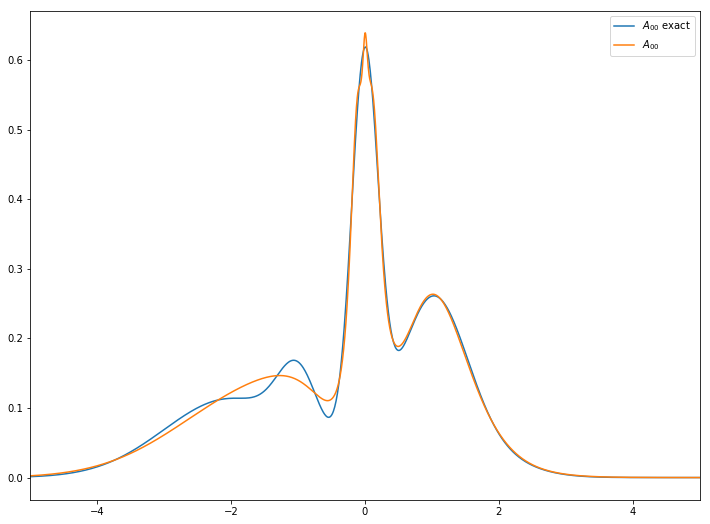

In [17]:
plt.rcParams['figure.figsize'] = [12, 9]
w_out=np.array([v.value for v in GR.mesh])
plt.plot(w,A00,label='$A_{00}$ exact')
plt.plot(w_out,A00_out,label='$A_{00}$')
plt.xlim([wl,wr])
plt.ylabel('')
plt.legend()

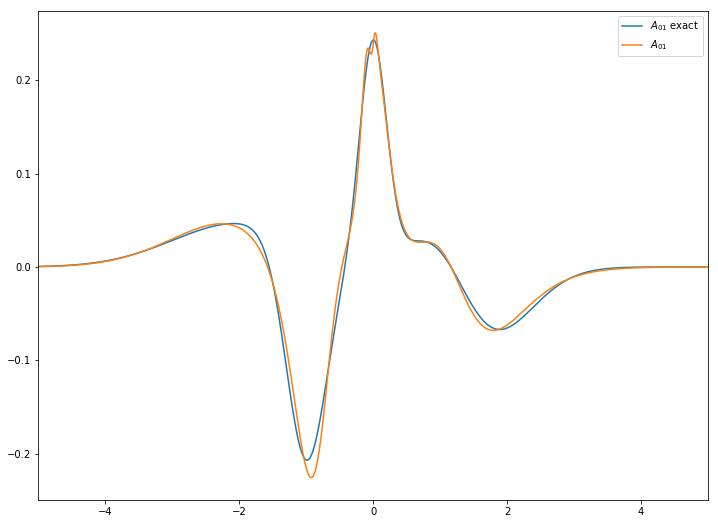

In [18]:
plt.plot(w,A01,label='$A_{01}$ exact')
plt.plot(w_out,A01_out,label='$A_{01}$')
plt.xlim([wl,wr])
plt.ylabel('')
plt.legend()

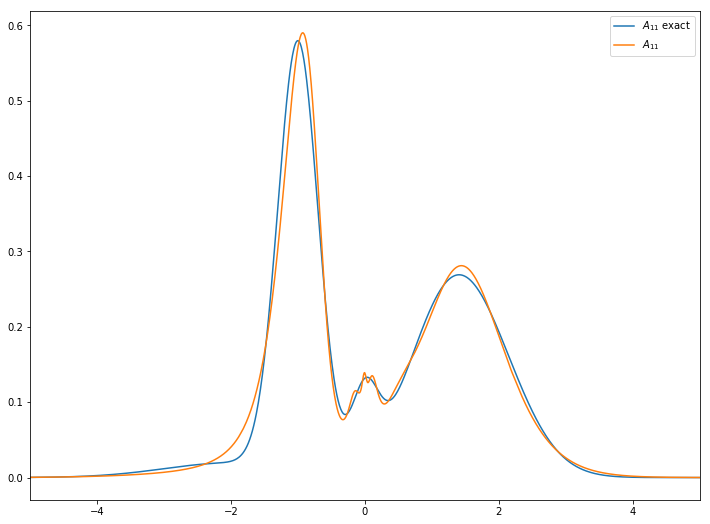

In [19]:
plt.plot(w,A11,label='$A_{11}$ exact')
plt.plot(w_out,A11_out,label='$A_{11}$')
plt.xlim([wl,wr])
plt.ylabel('')
plt.legend()

In [20]:
os.chdir("..")
su.rmtree(dir_name)